In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/histogram-equalized-bh/hist_ew/validation/no/173.png
/kaggle/input/histogram-equalized-bh/hist_ew/validation/no/94.png
/kaggle/input/histogram-equalized-bh/hist_ew/validation/no/48.png
/kaggle/input/histogram-equalized-bh/hist_ew/validation/no/61.png
/kaggle/input/histogram-equalized-bh/hist_ew/validation/no/37.png
/kaggle/input/histogram-equalized-bh/hist_ew/validation/no/148.png
/kaggle/input/histogram-equalized-bh/hist_ew/validation/no/35.png
/kaggle/input/histogram-equalized-bh/hist_ew/validation/no/177.png
/kaggle/input/histogram-equalized-bh/hist_ew/validation/no/142.png
/kaggle/input/histogram-equalized-bh/hist_ew/validation/no/104.png
/kaggle/input/histogram-equalized-bh/hist_ew/validation/no/133.png
/kaggle/input/histogram-equalized-bh/hist_ew/validation/no/70.png
/kaggle/input/histogram-equalized-bh/hist_ew/validation/no/162.png
/kaggle/input/histogram-equalized-bh/hist_ew/validation/no/186.png
/kaggle/input/histogram-equalized-bh/hist_ew/validation/no/73.png
/k

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import cv2
import shutil
import itertools

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

#init_notebook_mode(connected=True)
RANDOM_SEED = 42

In [5]:
train_dir = "../input/histogram-equalized-bh/hist_ew/train/"
validation_dir = "../input/histogram-equalized-bh/hist_ew/validation/"
test_dir = "../input/histogram-equalized-bh/hist_ew/test/"

In [9]:
def load_data(dir_path):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [10]:
X_train, y_train, labels = load_data(train_dir)
X_test, y_test, _ = load_data(test_dir)
X_val, y_val, _ = load_data(validation_dir)

100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


1536 images loaded from ../input/histogram-equalized-bh/hist_ew/train/ directory.


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


480 images loaded from ../input/histogram-equalized-bh/hist_ew/test/ directory.


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

384 images loaded from ../input/histogram-equalized-bh/hist_ew/validation/ directory.


In [11]:
X_train = np.array([cv2.resize(image, (224, 224)) for image in X_train])
X_test = np.array([cv2.resize(image, (224, 224)) for image in X_test])
X_val = np.array([cv2.resize(image, (224, 224)) for image in X_val])

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1536, 224, 224, 3)
(480, 224, 224, 3)
(384, 224, 224, 3)


In [ ]:
# X_train = np.expand_dims(X_tr, axis=-1) 
# X_test = np.expand_dims(X_te, axis=-1)
# X_val = np.expand_dims(X_vl, axis=-1)

# X_train=X_train.reshape((1536, 224, 224, 1))
# X_test=X_test.reshape((480, 224, 224,1))
# X_val=X_val.reshape((384, 224, 224,1))

# print(X_train.shape)
# print(X_test.shape)
# print(X_val.shape)

In [ ]:
# X_train=X_train.astype("float32")
# X_test=X_test.astype("float32")
# X_val=X_val.astype("float32")

In [12]:
input_shape = (224,224, 3)
batch_size = 32

In [13]:
training_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [26]:
train_generator = training_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

val_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1536 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [30]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.40),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.40),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.40),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 64)       

In [31]:
model.compile(
    loss='binary_crossentropy',
    optimizer= RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

In [32]:
EPOCHS = 100
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1)

es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)
filename = 'he_data_model_1.h5'
check_pt = ModelCheckpoint(
    filename,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True
)

history = model.fit(train_generator, epochs=EPOCHS, batch_size=16, validation_data=val_generator, callbacks=[reduce_lr, es, check_pt])

Epoch 1/100
48/48 [==============================] - 7s 118ms/step - loss: 0.6930 - accuracy: 0.5163 - val_loss: 0.6912 - val_accuracy: 0.5703

Epoch 00001: val_accuracy improved from -inf to 0.57031, saving model to he_data_model_1.h5
Epoch 2/100
48/48 [==============================] - 6s 124ms/step - loss: 0.6911 - accuracy: 0.5592 - val_loss: 0.6894 - val_accuracy: 0.5104

Epoch 00002: val_accuracy did not improve from 0.57031
Epoch 3/100
48/48 [==============================] - 5s 109ms/step - loss: 0.6886 - accuracy: 0.5436 - val_loss: 0.6819 - val_accuracy: 0.6250

Epoch 00003: val_accuracy improved from 0.57031 to 0.62500, saving model to he_data_model_1.h5
Epoch 4/100
48/48 [==============================] - 6s 116ms/step - loss: 0.6838 - accuracy: 0.5690 - val_loss: 0.6665 - val_accuracy: 0.6536

Epoch 00004: val_accuracy improved from 0.62500 to 0.65365, saving model to he_data_model_1.h5
Epoch 5/100
48/48 [==============================] - 5s 111ms/step - loss: 0.6673 - acc

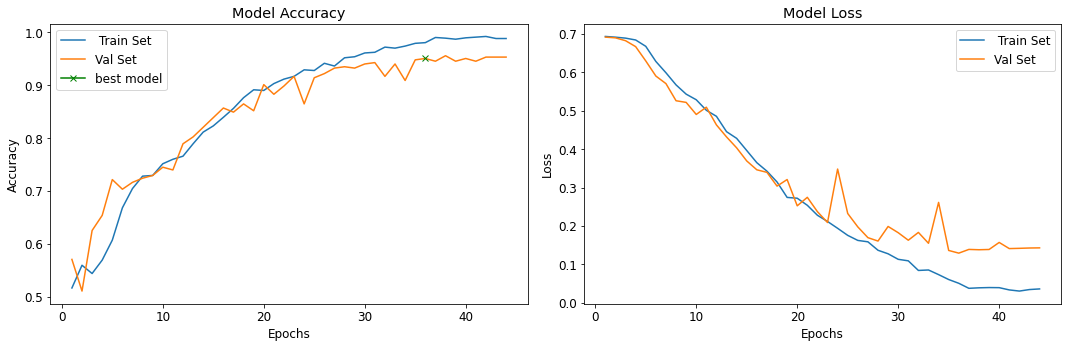

In [33]:
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history["accuracy"], label=' Train Set')
plt.plot(epochs_range, history.history["val_accuracy"], label='Val Set')
plt.plot( 36, 0.95052, marker="x", color="g", label="best model")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history["loss"], label=' Train Set')
plt.plot(epochs_range, history.history["val_loss"], label='Val Set')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [34]:
from tensorflow.keras.models import load_model
saved_model = load_model('./he_data_model_1.h5')

Train: 0.9518, Val: 0.9036
Validation Accuracy = 0.9036
Precision: 0.928177
Recall: 0.875000
F1 score: 0.900804
Cohens kappa: 0.807292
ROC AUC: 0.903646
[[179  13]
 [ 24 168]]
True positive: 168 , True negative: 179 , False positive: 13 , False negative: 24
Sensitivity: 0.8750
Specificity: 0.9323


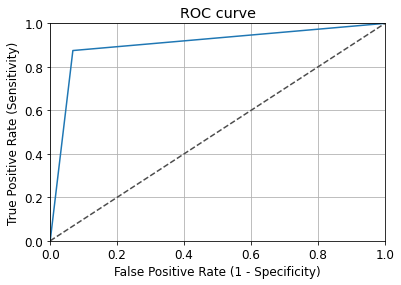

In [35]:
from sklearn.metrics import roc_curve

# validate on test set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)

print('Train: %.4f, Val: %.4f' % (train_acc, val_acc))

accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_val, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

fpr, tpr, thresholds = roc_curve(y_val, predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Train: 0.9518, Test: 0.9125
Test Accuracy = 0.9125
Precision: 0.958333
Recall: 0.862500
F1 score: 0.907895
Cohens kappa: 0.825000
ROC AUC: 0.912500
[[231   9]
 [ 33 207]]
True positive: 207 , True negative: 231 , False positive: 9 , False negative: 33
Sensitivity: 0.8625
Specificity: 0.9625


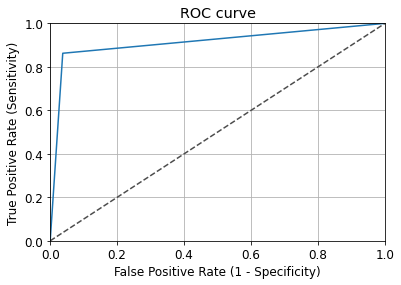

In [36]:
# validate on test set (saved model)
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)


sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

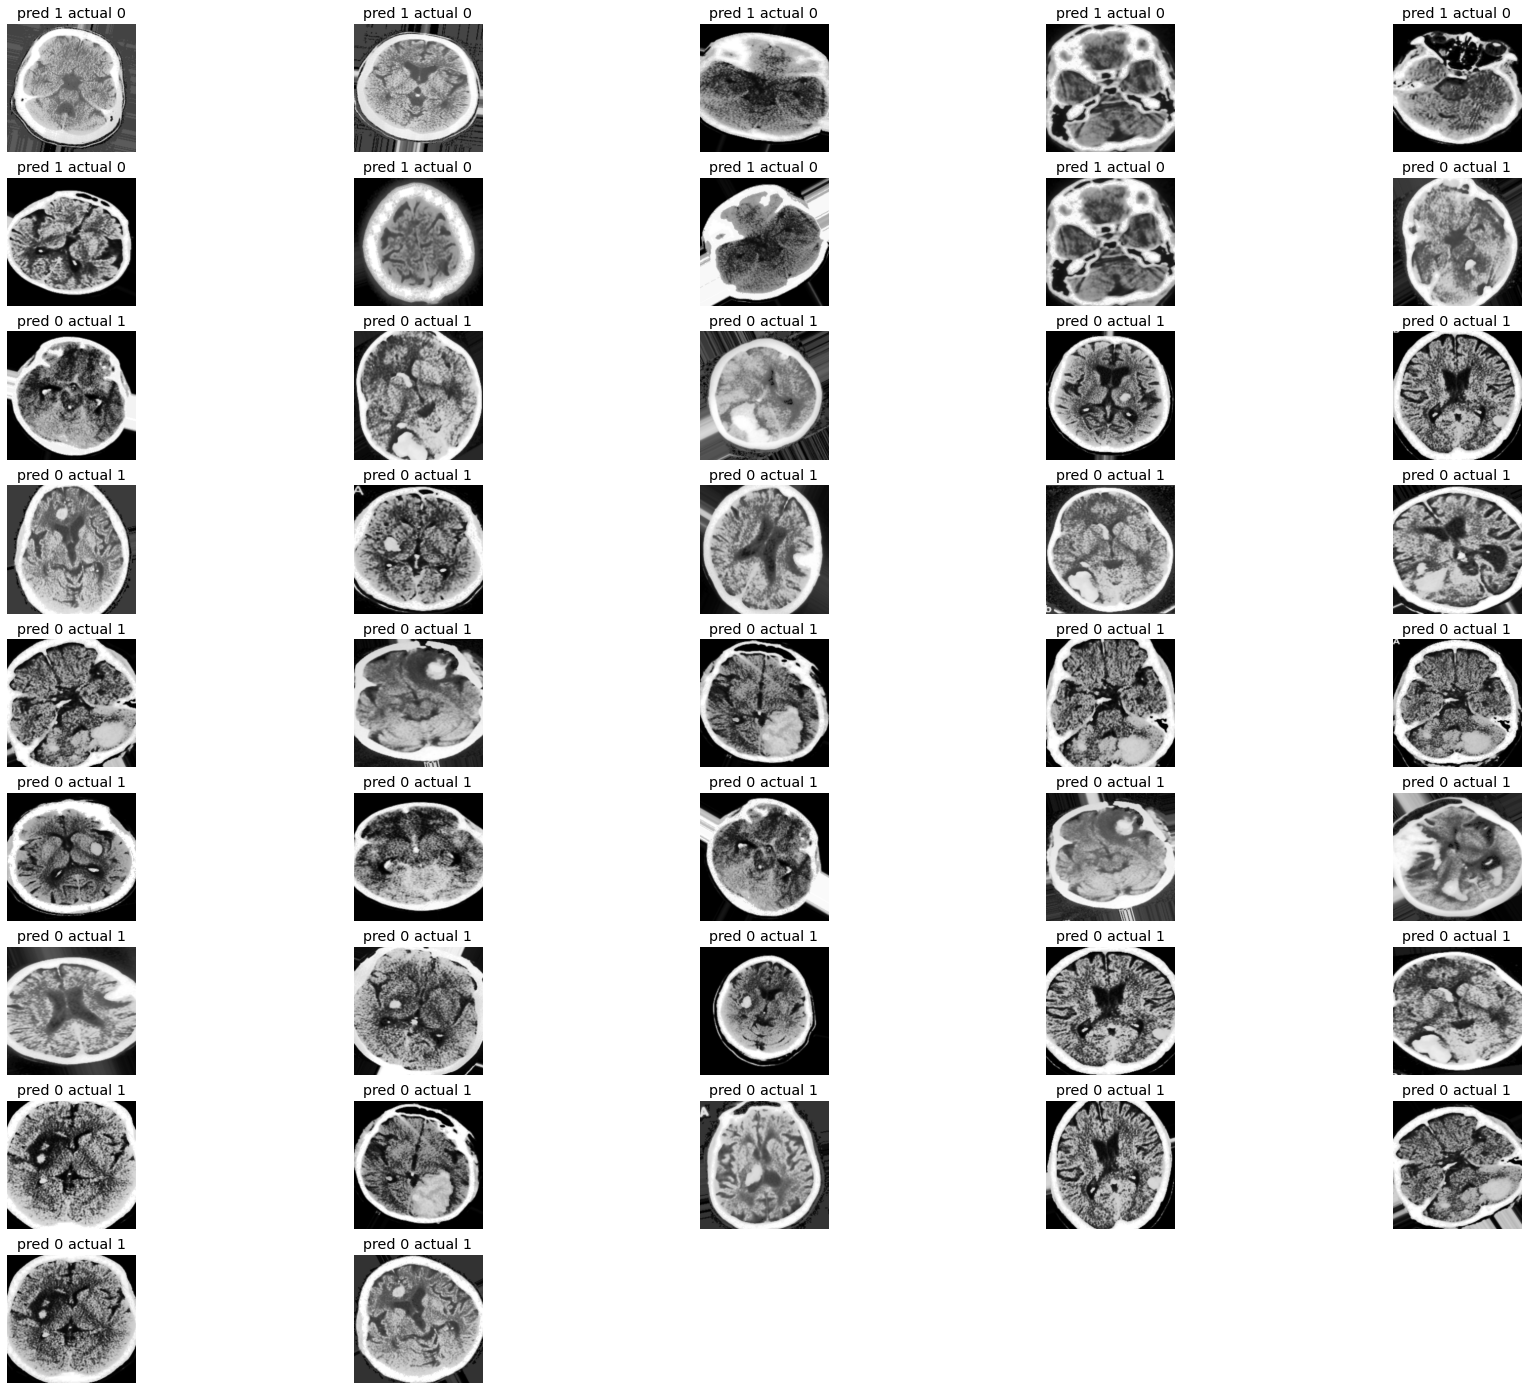

In [38]:
predicted = model.predict(X_test)
predicted = [1 if x>0.5 else 0 for x in predicted]
#print_images=True
#if print_images:
rows = 9
col = 5
j = 0
fig = plt.figure(figsize=(30, 25))

for i in range(len(predicted)):
    if predicted[i] != y_test[i]:
        j = j + 1
        fig.add_subplot(rows, col, j)
        plt.imshow(X_test[i])
        plt.axis('off')
        plt.title("pred "+str(predicted[i])+" actual "+str(y_test[i]))